In [2]:
%config IPCompleter.greedy=True
import pandas as pd
import re,nltk, string, unicodedata
import matplotlib.pyplot as plt
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
pd.set_option('display.max_colwidth', None)
pd.options.display.max_rows = 500
df = pd.read_csv("Data/formattedData.csv", sep=";").dropna()
df = df[df['Area']!= 'Confianza General']

In [3]:
dfSntTok = df
dfSntTok["Respuesta"] = dfSntTok["Respuesta"].apply(nltk.sent_tokenize)
dfSntTok = dfSntTok[dfSntTok['Respuesta'].apply(len) >= 1].dropna()
arrayExterno = []
def separeSentences(row):
    if type(row['Respuesta']) != str:
        if len(row['Respuesta']) == 1:
            row['Respuesta'] = row['Respuesta'][0]
            return row
        else:
            area = row['Area']
            dimension = row['Dimension']
            for sent in row['Respuesta']:
                tempArray = []
                tempArray.append(area)    
                tempArray.append(dimension)
                tempArray.append(sent)
                arrayExterno.append(tempArray)
            row['Respuesta'] = ""
            return row
    else:
        return row

dfSntTok = dfSntTok.apply(separeSentences, axis = 1).copy()
dfSntTok = pd.concat([dfSntTok,
                      pd.DataFrame(arrayExterno, columns=["Area", "Dimension", "Respuesta"])],ignore_index=True).dropna()

In [4]:
# df_aux = dfSntTok.copy()
# df_aux['Dimension'] = df_aux.Dimension.apply(lambda x: list_dim.index(x))
# df_aux.groupby(['Area', 'Dimension']).count().to_csv('count.csv')

In [34]:
df[df.Area  == "Gobierno Corporativo"][21392+10000:21392+100010]#['Dimension']

,Area,Dimension,Respuesta
293909,Gobierno Corporativo,Integridad,"[He tenido personas que me atendieron bien, como otras que fueron irrespetuosas]"
293910,Gobierno Corporativo,Integridad,"[He tenido un caso que me decepciono, el resto todo muy bien.]"
293911,Gobierno Corporativo,Integridad,"[He visto comentarios con lo que considero es una falta de respeto de jefes a subordinados., No es mí caso personal.]"
293912,Gobierno Corporativo,Integridad,[He visto como empleados de la empresa sacan insumos o materiales de la empresa sin autorización]
293913,Gobierno Corporativo,Integridad,"[he visto cosas muy malas, hay un mal trato, producto del stress o nos estamos olvidando de ser personas.]"
...,...,...,...
302492,Gobierno Corporativo,Integridad,[Alguna vez alguna discusión]
302494,Gobierno Corporativo,Integridad,[Inclusión en algunas actividades sociales y recreativas]
302506,Gobierno Corporativo,Integridad,[no tengo comentarios]
302509,Gobierno Corporativo,Integridad,[NO HAY]


In [5]:
def normalizeText(tokens):
    tokens = tokens.replace(r'_', r'').replace(r'¨¢', r'a').replace(r'¨¦',r'e').replace(r'¨ª', r'i')\
        .replace(r'¨²', r'u').replace(r'¨®', r'o').replace(r'?', r'n').replace(r'á', r'a')\
        .replace(r'é',r'e').replace(r'í', r'i').replace(r'ó', r'o').replace(r'ú', r'u').replace(r'ñ', r'n')\
        .replace('Á', r'A').replace(r'É',r'E').replace(r'Í', r'I').replace(r'Ó', r'O').replace(r'Ú', r'U')\
        .replace(r'Ñ', r'N')
    tokens = re.sub(r'[^\w\s ÑñáéíóúÁÉÍÓÚ]', '', tokens)
    tokens = re.sub('\d','',tokens)
    return tokens.lower()

stop = stopwords.words('spanish')
def removeStopWords(tokens, stopword):
    new_ = []
    for token in tokens:
        if token not in stopword and token not in ['etc']:
            new_.append(token)
    return new_

dfNorm = dfSntTok.copy()
dfNorm["Respuesta"] = dfNorm["Respuesta"].apply(normalizeText)

In [6]:
dfNorm["Respuesta"] = dfNorm["Respuesta"].apply(nltk.word_tokenize)

{'whiskers': [<matplotlib.lines.Line2D at 0x7f1d62e13250>,
 'caps': [<matplotlib.lines.Line2D at 0x7f1d644a1310>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f1d62e13940>],
 'medians': [<matplotlib.lines.Line2D at 0x7f1d632cbee0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f1d62e7a1c0>],
 'means': []}

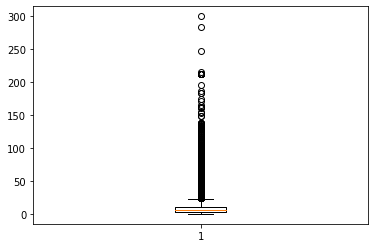

In [7]:
plt.subplots()
dataToPlot = [dfNorm["Respuesta"].apply(len)]
plt.boxplot(dataToPlot)

In [8]:
dfNorm["Respuesta"] = dfNorm["Respuesta"].apply(removeStopWords, stopword = stop)

In [15]:
dfNorm = dfNorm[dfNorm['Respuesta'].map(len) > 3]
dfNorm["Respuesta"] = dfNorm["Respuesta"].apply(lambda x: x if len(x) < 10 else x[:10])
dfNorm["Respuesta"].apply(len).describe()

count    148618.000000
mean          6.521014
std           2.199150
min           4.000000
25%           5.000000
50%           6.000000
75%           8.000000
max          10.000000
Name: Respuesta, dtype: float64

In [16]:
dfNorm["Respuesta"].apply(len).describe()

count    148618.000000
mean          6.521014
std           2.199150
min           4.000000
25%           5.000000
50%           6.000000
75%           8.000000
max          10.000000
Name: Respuesta, dtype: float64

In [17]:
max_quantity = max(dfNorm.groupby(['Area','Dimension']).count().Respuesta)
array_groups_to_remove = []
for name, group in dfNorm.groupby(['Area','Dimension']):
    if len(group) <= max_quantity/10:
        array_groups_to_remove.append(name)

dfNorm = dfNorm.apply(lambda x, arr_rem: None if (x['Area'],x['Dimension']) in arr_rem else x, axis = 1\
                      , arr_rem = array_groups_to_remove).dropna()

In [41]:
# df_aux = dfNorm.copy()
# df_aux['Dimension'] = df_aux.Dimension.apply(lambda x: list_dim.index(x))
# df_aux.groupby(['Area','Dimension']).count().to_csv("count2.csv")

In [18]:
lemmaDiccionario = {}
with open('Herramientas/lemma.txt', 'rb') as fichero:
    datos = (fichero.read().decode('utf8').replace(u'\r', u'').split(u'\n'))
    datos = ([avance.split(u'\t') for avance in datos])
for avance in datos:
    if len(avance) >1:
        lemmaDiccionario[avance[1]] = avance[0]
        
def lemmatize(word):
    return lemmaDiccionario.get(word, word + u'')
   
def lemmatize_words(words):
    new_words = []
    for palabra in words:
        new_word = lemmatize(palabra)
        new_words.append(new_word)
    return new_words

dfNorm["Respuesta"] = dfNorm["Respuesta"].apply(lemmatize_words)

In [ ]:
dfNorm.to_csv("Data/Flujo1.csv", sep=";", index=False)

In [19]:
Stemmer_spanish = SnowballStemmer('spanish')
def stemWordsArray(tokens, stemmer):
    new_ = []
    for token in tokens:
        new_.append(stemmer.stem(token))
    return new_

dfStemmer = dfNorm.copy()
dfStemmer['Respuesta'] = dfStemmer['Respuesta'].apply(stemWordsArray, stemmer = Stemmer_spanish)

In [46]:
#dfStemmer.to_csv("Data/Flujo2.csv", sep=";", index=False)


{'whiskers': [<matplotlib.lines.Line2D at 0x7f1d4f0321f0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f1d4f0328b0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f1d5f35ba60>],
 'medians': [<matplotlib.lines.Line2D at 0x7f1d4f032f70>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f1d4f035310>],
 'means': []}

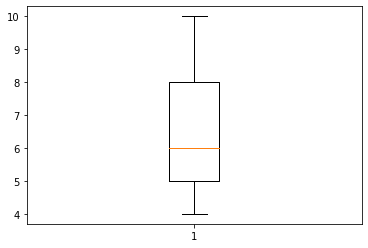

In [20]:
plt.subplots()
dataToPlot = [dfStemmer["Respuesta"].apply(len)]
plt.boxplot(dataToPlot)

In [22]:
dfStemmer["Respuesta"].apply(len).describe()

count    148618.000000
mean          6.521014
std           2.199150
min           4.000000
25%           5.000000
50%           6.000000
75%           8.000000
max          10.000000
Name: Respuesta, dtype: float64

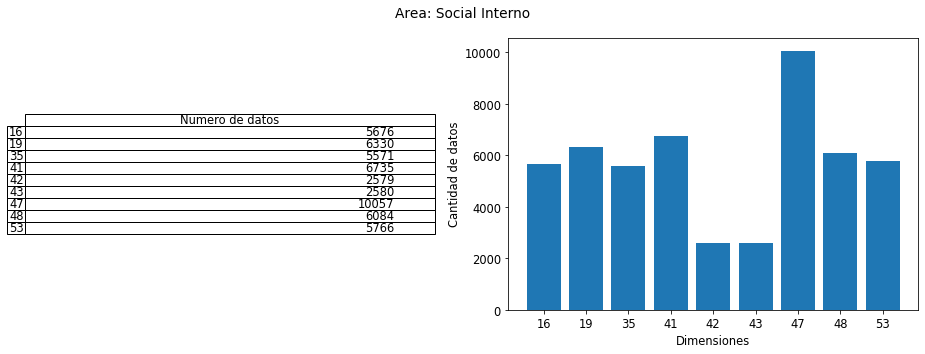

In [205]:
import matplotlib
matplotlib.rcParams.update({'font.size': 11.5})


area = "Social Interno"

aux = dfStemmer.copy()
aux = aux[aux['Area'] == area]
aux['Dimension'] = aux.Dimension.apply(lambda x: str(list_dim.index(x)))
aux = aux[['Dimension', 'Respuesta']].groupby('Dimension').count()

width = 0.35
fig, ax = plt.subplots(1,2, figsize=(13,5))
ax[1].bar(list(aux.index), aux.Respuesta)
ax[1].set_ylabel('Cantidad de datos')
ax[1].set_xlabel('Dimensiones')
fig.suptitle('Area: '+area)

fig.patch.set_visible(False)
ax[0].axis('off')
ax[0].axis('tight')
ax[0].table(cellText=[[x] for x in aux.Respuesta], colLabels=["Numero de datos"], rowLabels=list(aux.index), loc='center')
fig.tight_layout()
plt.show()